In [60]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
#Load the datasets
users_df = pd.read_csv(r"C:\Users\tammy\Downloads\1481069814relaxchallenge\relaxchallenge\takehome_users.csv", encoding = 'latin-1')
engagement_df = pd.read_csv(r"C:\Users\tammy\Downloads\1481069814relaxchallenge\relaxchallenge\takehome_user_engagement.csv", encoding = 'latin-1')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Convert timestamps to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [6]:
#sort engagement by user and time
engagement_df = engagement_df.sort_values(by=['user_id','time_stamp'])



In [7]:
# Group by user_id and apply a rolling count to find users who logged in at least 3 times in a 7-day window
def is_adopted_user(group):
    group['adopted'] = group['time_stamp'].rolling(7).count() >= 3
    return group

# Apply the function to each user's logins
engagement_df = engagement_df.groupby('user_id').apply(is_adopted_user)

In [8]:
# Reset index to remove 'user_id' from the index level and ensure it's only a column
engagement_df.reset_index(drop=True, inplace=True)

In [9]:
# Get unique user_id and their adoption status
adopted_users = engagement_df.groupby('user_id')['adopted'].max().reset_index()


In [10]:
adopted_users.head()

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


In [11]:
# Merge adoption status with the users data
users_df = users_df.merge(adopted_users, left_on='object_id', right_on='user_id', how='left')

In [12]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,False


In [13]:
users_df['adopted'].isnull().sum()

3177

In [14]:
# Fill NaN values for non-adopted users with 0 (not adopted)
users_df['adopted'].fillna(0, inplace=True)

In [15]:
# Convert last_session_creation_time from Unix timestamp to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

In [16]:
# Create new features
users_df['days_since_signup'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days
users_df['is_invited'] = users_df['invited_by_user_id'].notnull().astype(int)

In [17]:
users_df['days_since_signup'].isnull().sum()

3177

In [18]:
users_df['days_since_signup'].fillna(users_df['days_since_signup'].mean(), inplace=True)

In [19]:
# Drop unnecessary columns for modeling
users_df = users_df.drop(columns=['name', 'email', 'org_id', 'user_id', 'invited_by_user_id', 'creation_time', 'last_session_creation_time'])

In [30]:
users_df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,days_since_signup,is_invited
0,1,GUEST_INVITE,1,0,False,0.0,1
1,2,ORG_INVITE,0,0,True,136.0,1
2,3,ORG_INVITE,0,0,False,0.0,1
3,4,GUEST_INVITE,0,0,False,1.0,1
4,5,GUEST_INVITE,0,0,False,5.0,1


In [31]:
users_df1 = pd.get_dummies(users_df, columns=['creation_source'], dtype ='int')

In [32]:
users_df1.dtypes

object_id                               int64
opted_in_to_mailing_list                int64
enabled_for_marketing_drip              int64
adopted                                object
days_since_signup                     float64
is_invited                              int32
creation_source_GUEST_INVITE            int32
creation_source_ORG_INVITE              int32
creation_source_PERSONAL_PROJECTS       int32
creation_source_SIGNUP                  int32
creation_source_SIGNUP_GOOGLE_AUTH      int32
dtype: object

In [37]:
#Using Label Encoder on the dependent Variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
users_df1['adopted'] = label_encoder.fit_transform(users_df1['adopted'])

In [41]:
# Verify the encoding
print("adopted users counts after encoding:")
print(users_df1['adopted'].value_counts())

adopted users counts after encoding:
adopted
0    10369
1     1631
Name: count, dtype: int64


In [42]:
# Features and target variable
X = users_df1.drop(columns=['adopted'])
y = users_df1['adopted']

In [43]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Train a logistic regression model
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, class_weight= None, random_state=None, solver='lbfgs', max_iter=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

C:\Users\tammy\anaconda3\ANACONDA\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9820833333333333
ROC-AUC Score: 0.9845809986816083
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2072
           1       0.99      0.88      0.93       328

    accuracy                           0.98      2400
   macro avg       0.98      0.94      0.96      2400
weighted avg       0.98      0.98      0.98      2400



In [62]:
# Train a Random Forest model
rf_model = RandomForestClassifier(max_depth=40, max_features='log2',min_samples_leaf = 10, min_samples_split=10)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Random Forest ROC-AUC Score: {roc_auc_rf}")

Random Forest Accuracy: 0.9845833333333334
Random Forest ROC-AUC Score: 0.9984255815048497


In [ ]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

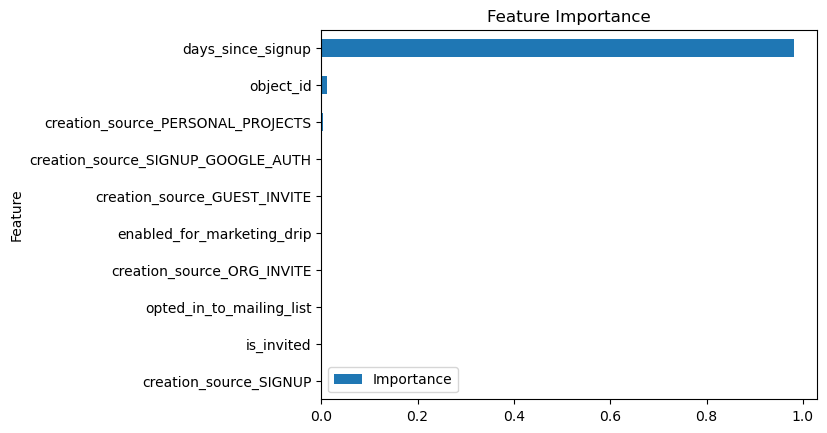

In [61]:
# Plot the feature importances
importances_df.plot(kind='barh', x='Feature', y='Importance', title='Feature Importance')
plt.gca().invert_yaxis()
plt.show()